In [1]:
using DataFrames, CSV, DelimitedFiles

CODE_ROOT = pwd() * "/../.."

include(CODE_ROOT * "/visualization.jl")

vertexHeatMapMesh (generic function with 1 method)

In [ ]:
function latestfile(dir, filterfunc)
    return filter(filterfunc, readdir(dir, join=true))[end]
end

latestfile (generic function with 1 method)

In [ ]:
using Statistics

In [ ]:
nCellsX = 128
jprocs = 2048
fprocs = 2048

2048

In [5]:
fname = latestfile(CODE_ROOT * "/output/kelvinwave/resolution$(nCellsX)x$(nCellsX)/procs$(jprocs)/steps10/nvlevels100/", x->x[end-3:end] == ".txt")
df = DataFrame(CSV.File(fname))

runs = filter(col->startswith(col,"sim_time"), names(df))[2:end]
mpis = filter(col->startswith(col,"mpi_time"), names(df))[2:end]
juliasimmean = 1/length(runs) * sum(Array(df[:,runs]), dims=2)
juliampimean = 1/length(mpis) * sum(Array(df[:,mpis]), dims=2)
juliameans = juliasimmean .+ juliampimean


fortranfnamesim = latestfile(CODE_ROOT * "/output/kelvinwave/fortranperformance/resolution$(nCellsX)x$(nCellsX)/", x -> occursin("$fprocs", x) && x[end-3:end] == ".txt" && occursin("runtime", x))
fortranfnamempi = latestfile(CODE_ROOT * "/output/kelvinwave/fortranperformance/resolution$(nCellsX)x$(nCellsX)/", x -> occursin("$fprocs", x) && x[end-3:end] == ".txt" && occursin("halotime", x))
fortransimtiming = readdlm(fortranfnamesim, skipstart=8)
fortranmpitiming = readdlm(fortranfnamempi, skipstart=8)
fortransimmean = fortransimtiming[:,end] #./ 4
fortranmpimean = fortranmpitiming[:,end]
fortransimstd = dropdims( std(Array(fortransimtiming[:,2:end-1]), dims=2), dims=2)
fortranmpistd = dropdims( std(Array(fortranmpitiming[:,2:end-1]), dims=2), dims=2)
fortranprocs = fortransimtiming[:,1]

juliasimstd = std(Array(df[:,runs]), dims=2)
juliampistd = std(Array(df[:,mpis]), dims=2)
;

In [6]:
df

Row,procs,sim_time1,sim_time2,sim_time3,sim_time4,sim_time5,sim_time6,sim_time7,sim_time8,sim_time9,sim_time10,sim_time11,sim_time12,mpi_time1,mpi_time2,mpi_time3,mpi_time4,mpi_time5,mpi_time6,mpi_time7,mpi_time8,mpi_time9,mpi_time10,mpi_time11,mpi_time12,max_error,l2_error
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,2.0,2.29158,2.23429,2.14739,2.36022,2.13456,2.14854,2.14279,2.1397,2.14703,2.11966,2.16542,2.12216,2.42818,0.0129819,0.262827,0.0194904,0.0540708,0.0470448,0.00624587,0.0411367,0.0062472,0.0604141,0.0174819,0.0399543,0.000332521,0.000115771
2,4.0,1.1032,1.13494,1.14378,1.16422,1.12451,1.14354,1.14911,1.15553,1.12713,1.15203,1.15138,1.13664,4.75499,0.0813813,0.10825,0.0925119,0.126903,0.0714018,0.331201,0.0957929,0.0898913,0.10079,0.0586637,0.128065,0.000337382,0.000157937
3,8.0,0.554074,0.57833,0.555181,0.556186,0.568604,0.568669,0.570349,0.585834,0.555948,0.555888,0.569286,0.570363,4.84014,0.0378186,0.142736,0.0944124,0.0313385,0.0865249,0.0815271,0.0635567,0.303337,0.0430229,0.0959136,0.0727703,2.43411e-5,4.44424e-6
4,16.0,0.330284,0.29297,0.293269,0.293985,0.295465,0.300527,0.300042,0.300797,0.299198,0.3005,0.315934,0.293391,4.59059,0.140388,0.0408761,0.058883,0.0425593,0.0867405,0.148143,0.0187868,0.0532283,0.0173181,0.104926,0.058159,0.000426889,0.000168255
5,32.0,0.149984,0.150847,0.150221,0.151501,0.150425,0.151979,0.154791,0.153706,0.153167,0.155171,0.154095,0.162922,4.76058,0.0884616,0.226799,0.126081,0.0531397,0.0246708,0.0781764,0.129135,0.127596,0.207183,0.0589283,0.0605441,1.06922e-5,3.50938e-6
6,64.0,0.0856042,0.0809494,0.0810631,0.081056,0.0814183,0.0811943,0.0807146,0.0804757,0.0804724,0.0806728,0.0795581,0.0811799,5.13874,0.0334482,0.0345053,0.102087,0.131979,0.214237,0.172163,0.0132779,0.0133858,0.040915,0.163353,0.0397131,1.00266e-5,2.60362e-6
7,128.0,0.0415529,0.0405198,0.040517,0.0498213,0.0404729,0.040629,0.0405525,0.040817,0.0408892,0.0406935,0.0411,0.0411133,5.58629,0.0205442,0.0273779,0.0418848,0.0131254,0.0984577,0.0310687,0.15307,0.271366,0.117593,0.416373,0.139982,1.37755e-5,3.75396e-6
8,256.0,0.0234034,0.0226017,0.0224697,0.0223772,0.022436,0.0224284,0.0227323,0.0224111,0.0222502,0.0222867,0.0224209,0.0225629,6.29818,0.108896,0.223451,0.242289,0.0296539,0.115137,0.196766,0.100108,0.29671,0.693655,0.28532,0.255367,1.00929e-5,4.35622e-6
9,512.0,0.0177055,0.0176289,0.0172904,0.0172183,0.0174498,0.0173909,0.0172539,0.0171829,0.0169327,0.0170976,0.0171102,0.0172021,6.04698,0.0714141,0.0398208,0.0478855,0.0825327,0.0478468,0.165233,0.176498,0.266792,0.246181,0.262388,0.280908,0.000126269,3.13814e-5


In [7]:
fortranmpitiming[end:-1:1,:]

11×14 Matrix{Float64}:
    2.0  0.02588  0.03236  0.03252  …  0.03576  0.04154  0.03457  0.031225
    4.0  0.0876   0.07425  0.06664     0.0691   0.06213  0.07165  0.073137
    8.0  0.05655  0.05517  0.05626     0.06153  0.05575  0.05335  0.057931
   16.0  0.06614  0.16908  0.07074     0.06872  0.07326  0.06939  0.08032
   32.0  0.07731  0.04926  0.05597     0.07489  0.10974  0.07303  0.066925
   64.0  0.06131  0.0455   0.05198  …  0.05234  0.04793  0.04468  0.050522
  128.0  0.02784  0.02682  0.02758     0.02868  0.02664  0.03642  0.028374
  256.0  0.0172   0.01709  0.0181      0.01751  0.0168   0.0203   0.018657
  512.0  0.02551  0.0275   0.02572     0.0256   0.05458  0.02514  0.028111
 1024.0  0.02037  0.02103  0.02083     0.02097  0.02099  0.02043  0.020978
 2048.0  0.01607  0.01531  0.01582  …  0.0157   0.01574  0.01584  0.015896

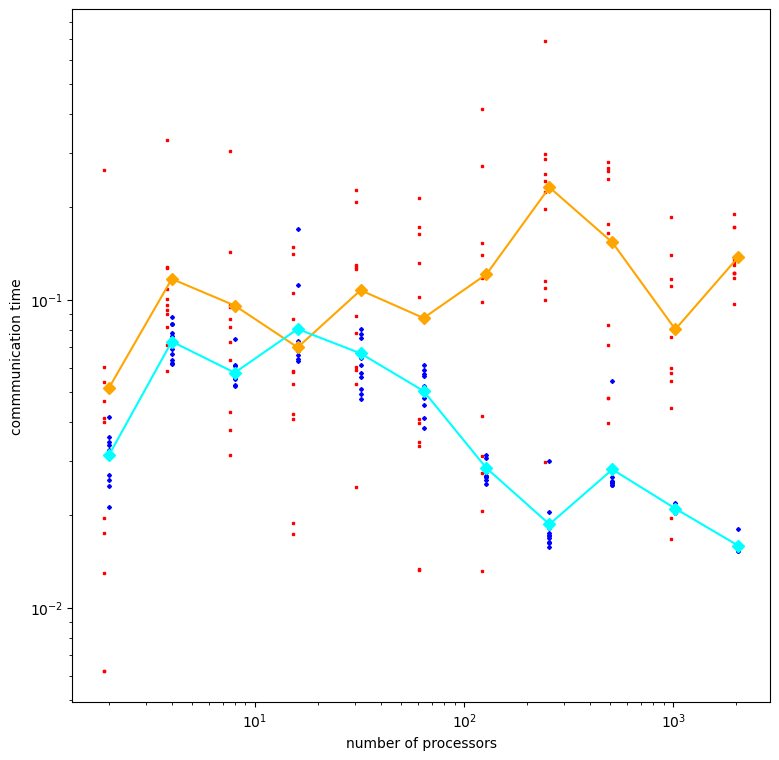

In [8]:
fig, ax = plt.subplots(1,1, figsize=(9,9))

ax.set_xscale("log")
ax.set_yscale("log")

for i in 1:length(mpis)
    mpi = mpis[i]
    ax.loglog(df.procs *0.95, df[:,mpi],               marker="s", linestyle="none", color="red",  markersize=2)
    ax.loglog(fortranmpitiming[:,1], fortranmpitiming[:,i+1], marker="D", linestyle="none", color="blue", markersize=2)
end

ax.loglog(df.procs, juliampimean, marker="D", color="orange")
ax.loglog(fortranmpitiming[:,1], fortranmpimean, marker="D", color="cyan")

ax.set_xlabel("number of processors")
ax.set_ylabel("commmunication time")
;

In [9]:
function juliafortrantimesplits(nCellsX, jprocs=1024, fprocs=1024)
    # read julia data from file
    fname = latestfile(CODE_ROOT * "/output/kelvinwave/resolution$(nCellsX)x$(nCellsX)/procs$(jprocs)/steps10/nvlevels100/", x->x[end-3:end] == ".txt")
    df = DataFrame(CSV.File(fname))
    # get the simulation time and communication time columns, excluding the first one
    runs = filter(col->startswith(col,"sim_time"), names(df))[2:end]
    mpis = filter(col->startswith(col,"mpi_time"), names(df))[2:end]
    juliasimmean = dropdims( 1/length(runs) * sum(Array(df[:,runs]), dims=2), dims=2)
    # juliampimin = collect([minimum(df[i,mpis]) for i in 1:size(df,1)])
    juliampimean = dropdims( 1/length(mpis) * sum(Array(df[:,mpis]), dims=2), dims=2)
#     juliameans = juliasimmean .+ juliampimean
    juliasimstd = dropdims( std(Array(df[:,runs]), dims=2), dims=2)
    juliampistd = dropdims( std(Array(df[:,mpis]), dims=2), dims=2)
    # juliampidif = juliampimean - juliampimin


    # read fortran data from files
    fortranfnamesim = latestfile(CODE_ROOT * "/output/kelvinwave/fortranperformance/resolution$(nCellsX)x$(nCellsX)/", x -> occursin("$fprocs", x) && x[end-3:end] == ".txt" && occursin("runtime", x))
    fortranfnamempi = latestfile(CODE_ROOT * "/output/kelvinwave/fortranperformance/resolution$(nCellsX)x$(nCellsX)/", x -> occursin("$fprocs", x) && x[end-3:end] == ".txt" && occursin("halotime", x))
    fortransimtiming = readdlm(fortranfnamesim, skipstart=8)
    fortranmpitiming = readdlm(fortranfnamempi, skipstart=8)
    fortransimmean = fortransimtiming[:,end] #./ 4
    fortranmpimean = fortranmpitiming[:,end]
    fortransimstd = dropdims( std(Array(fortransimtiming[:,2:end-1]), dims=2), dims=2)
    fortranmpistd = dropdims( std(Array(fortranmpitiming[:,2:end-1]), dims=2), dims=2)
    fortranprocs = fortransimtiming[:,1]
    
    return juliasimmean, juliampimean, df.procs, fortransimmean, fortranmpimean, fortranprocs, fname, fortranfnamesim, juliasimstd, juliampistd, fortransimstd, fortranmpistd
end

juliafortrantimesplits (generic function with 3 methods)

In [10]:
function juliafortranmeans(nCellsX, jprocs=1024, fprocs=1024)
    juliasimmean, juliampimean, jprocs, fortransimmean, fortranmpimean, fortranprocs, fname, fortranfname, juliasimstd, juliampistd, fortransimstd, fortranmpistd = juliafortrantimesplits(nCellsX, jprocs, fprocs)
    
    return juliasimmean .+ juliampimean, jprocs, fortransimmean.+fortranmpimean, fortranprocs, fname, fortranfname
end

juliafortranmeans (generic function with 3 methods)

In [11]:
function strongscalingplot(juliameans, juliaprocs, fortranmeans, fortranprocs, nCellsX)

    perfectjulia = juliameans[1] * juliaprocs[1] ./ juliaprocs

    
    linewidth = 1
    linestyle = "-"
    markersize = 10
    tickfontsize = 15
    labelfontsize = 22.5
    titlefontsize = 25
    blue = "blue"
    red = "red"

    fig, ax = plt.subplots(figsize=(9,9))
    ax.loglog(juliaprocs, juliameans, label="Julia", linewidth=linewidth,linestyle="-",color=red,marker="s",markersize=markersize)
    ax.loglog(fortranprocs, fortranmeans, label="Fortran", linewidth=linewidth,linestyle="--",color=blue,marker="D",markersize=markersize)
    ax.loglog(juliaprocs, perfectjulia, label="Perfect scaling", linestyle=":", color="black", linewidth=2)


    ax.set_xticks(juliaprocs)
    ax.tick_params(axis="x", labelsize=tickfontsize)
    ax.tick_params(axis="y", labelsize=tickfontsize)
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    
    ax.set_xlabel("Number of processors", fontsize=labelfontsize, labelpad=10)
    ax.set_ylabel("Wall clock time elapsed during computation (s)", fontsize=labelfontsize, labelpad=10)
    ax.set_title("$(nCellsX)x$(nCellsX) Hexagonal Mesh", fontsize=titlefontsize, fontweight="bold", y=1.02)
    ax.legend(loc="upper right", fontsize=labelfontsize-2.5)

    ax.grid(which="both")
    plt.tight_layout()

    return fig, ax
end

strongscalingplot (generic function with 1 method)

In [12]:
savefigs = true

true

/global/u2/r/rstrauss/repos/MPAS_Ocean_Julia/output/kelvinwave/../../output/kelvinwave/resolution128x128/procs2048/steps10/nvlevels100/2022-12-23T13:27:36.395.txt
/global/u2/r/rstrauss/repos/MPAS_Ocean_Julia/output/kelvinwave/../../output/kelvinwave/fortranperformance/resolution128x128/runtime_cori-haswell_32_2048_20221223_064811.txt
/global/u2/r/rstrauss/repos/MPAS_Ocean_Julia/output/kelvinwave/../../output/kelvinwave/resolution256x256/procs2048/steps10/nvlevels100/2022-12-23T13:34:23.663.txt
/global/u2/r/rstrauss/repos/MPAS_Ocean_Julia/output/kelvinwave/../../output/kelvinwave/fortranperformance/resolution256x256/runtime_cori-haswell_32_2048_20221223_073949.txt
/global/u2/r/rstrauss/repos/MPAS_Ocean_Julia/output/kelvinwave/../../output/kelvinwave/resolution512x512/procs2048/steps10/nvlevels100/2022-12-23T13:56:37.756.txt
/global/u2/r/rstrauss/repos/MPAS_Ocean_Julia/output/kelvinwave/../../output/kelvinwave/fortranperformance/resolution512x512/runtime_cori-haswell_32_2048_20221223_080

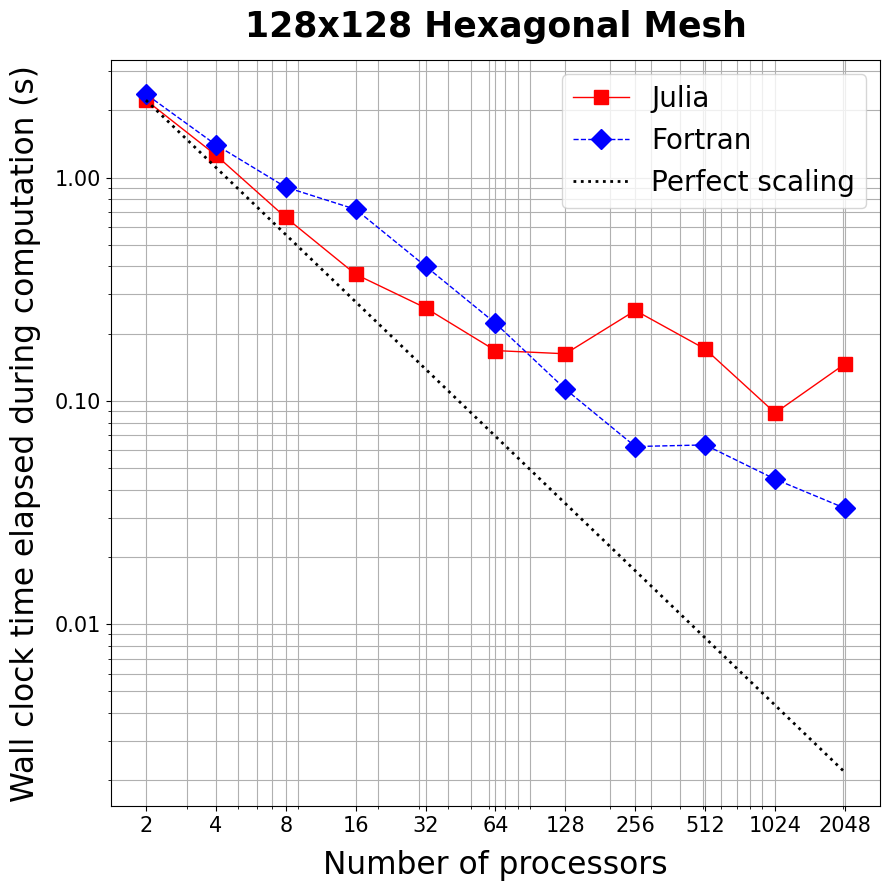

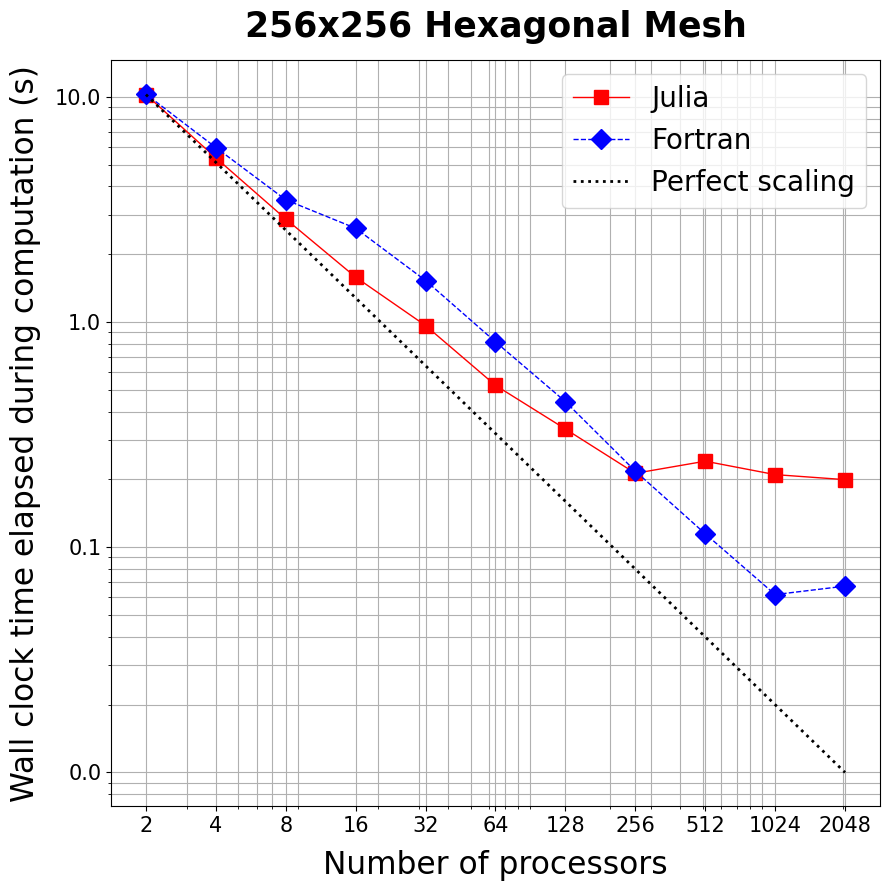

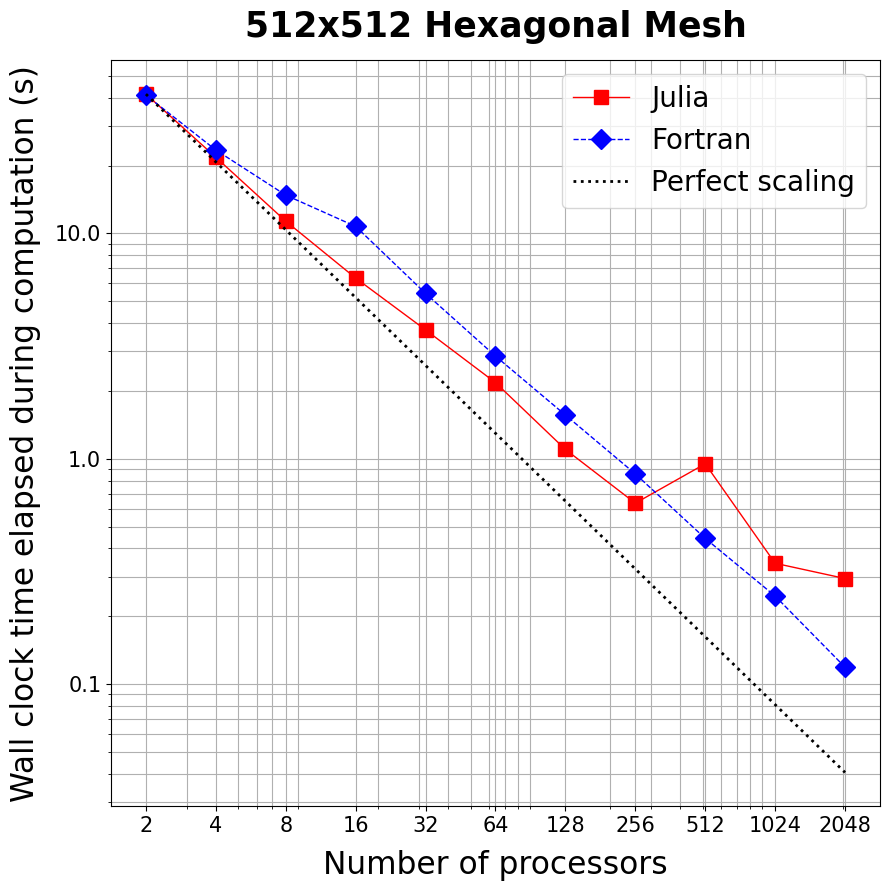

In [13]:
for nCellsX in [128, 256, 512]
    jt, jp, ft, fp, juliafn, fortranfn = juliafortranmeans(nCellsX, 2048, 2048)
    fig, ax = strongscalingplot(jt, jp, ft, fp, nCellsX)
    if savefigs
        fig.savefig("$(juliafn)_scaling$(nCellsX)x.pdf")
    end
    println(juliafn)
    println(fortranfn)
end

In [14]:
function strongscalingplot2(juliasim, juliasimstd, juliampi, juliampistd, juliaprocs, fortransim, fortransimstd, fortranmpi, fortranmpistd, fortranprocs, nCellsX)

    perfectjulia = (juliampi[1] + juliasim[1]) * juliaprocs[1] ./ juliaprocs

    linewidth = 1
    linestyle = "-"
    markersize = 10
    tickfontsize = 15
    labelfontsize = 22.5
    titlefontsize = 25
    blue = "blue"
    red = "red"

    fig, ax = plt.subplots(figsize=(9,9))
    ax.set_xscale("log")
    ax.set_yscale("log")
    
    ax.errorbar(juliaprocs, juliampi, yerr=juliampistd, label="Julia communication", linewidth=linewidth,linestyle="--",color=red,marker="P",markersize=markersize)
    ax.errorbar(fortranprocs, fortranmpi, yerr=fortranmpistd, label="Fortran communication", linewidth=linewidth,linestyle="--",color=blue,marker="X",markersize=markersize)
    
    ax.errorbar(juliaprocs, juliasim, yerr=juliasimstd, label="Julia computation", linewidth=linewidth,linestyle="-",color=red,marker="s",markersize=markersize)
    ax.errorbar(fortranprocs, fortransim, yerr=fortransimstd, label="Fortran computation", linewidth=linewidth,linestyle="-",color=blue,marker="D",markersize=markersize)
    
    
    ax.loglog(juliaprocs, perfectjulia, label="Perfect scaling", linestyle=":", color="black", linewidth=2)


    ax.set_xticks(juliaprocs)
    ax.tick_params(axis="x", labelsize=tickfontsize)
    ax.tick_params(axis="y", labelsize=tickfontsize)
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    
    ax.set_xlabel("Number of processors", fontsize=labelfontsize, labelpad=10)
    ax.set_ylabel("Wall clock time elapsed during computation (s)", fontsize=labelfontsize, labelpad=10)
    ax.set_title("$(nCellsX)x$(nCellsX) Hexagonal Mesh", fontsize=titlefontsize, fontweight="bold", y=1.02)
    ax.legend(loc="upper right", fontsize=labelfontsize-2.5)

    ax.grid(which="both")
    plt.tight_layout()

    return fig, ax
end

strongscalingplot2 (generic function with 1 method)

saved
/global/u2/r/rstrauss/repos/MPAS_Ocean_Julia/output/kelvinwave/../../output/kelvinwave/resolution128x128/procs2048/steps10/nvlevels100/2022-12-23T13:27:36.395.txt/global/u2/r/rstrauss/repos/MPAS_Ocean_Julia/output/kelvinwave/../../output/kelvinwave/fortranperformance/resolution128x128/runtime_cori-haswell_32_2048_20221223_064811.txt
saved
/global/u2/r/rstrauss/repos/MPAS_Ocean_Julia/output/kelvinwave/../../output/kelvinwave/resolution256x256/procs2048/steps10/nvlevels100/2022-12-23T13:34:23.663.txt/global/u2/r/rstrauss/repos/MPAS_Ocean_Julia/output/kelvinwave/../../output/kelvinwave/fortranperformance/resolution256x256/runtime_cori-haswell_32_2048_20221223_073949.txt
saved
/global/u2/r/rstrauss/repos/MPAS_Ocean_Julia/output/kelvinwave/../../output/kelvinwave/resolution512x512/procs2048/steps10/nvlevels100/2022-12-23T13:56:37.756.txt/global/u2/r/rstrauss/repos/MPAS_Ocean_Julia/output/kelvinwave/../../output/kelvinwave/fortranperformance/resolution512x512/runtime_cori-haswell_32_20

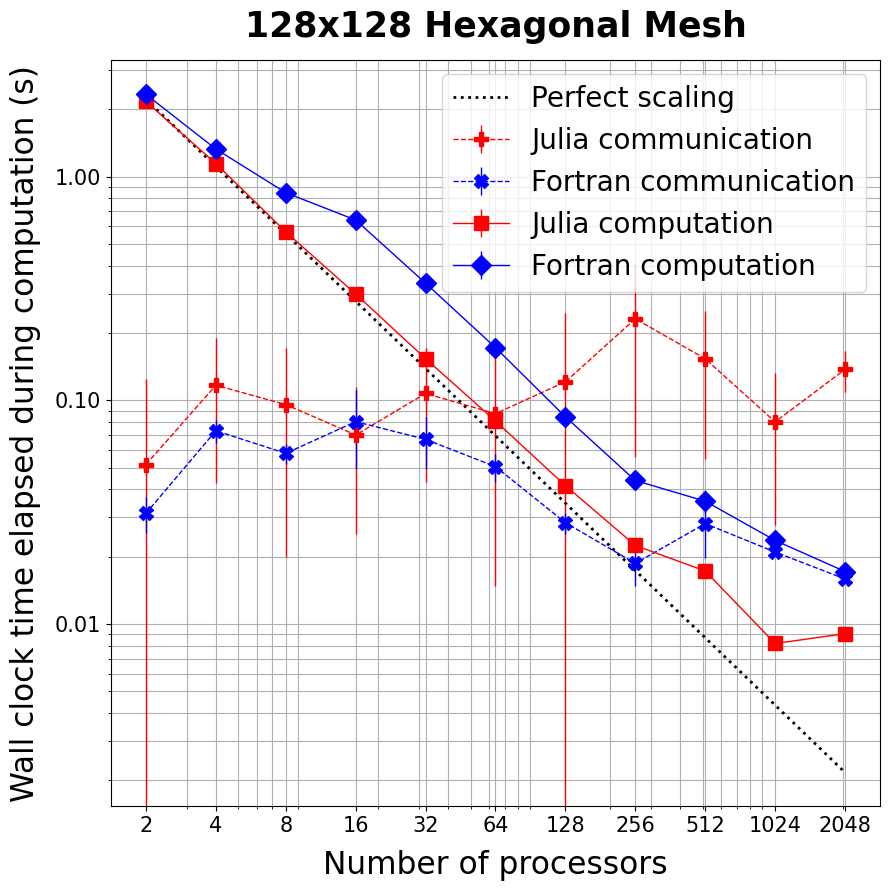

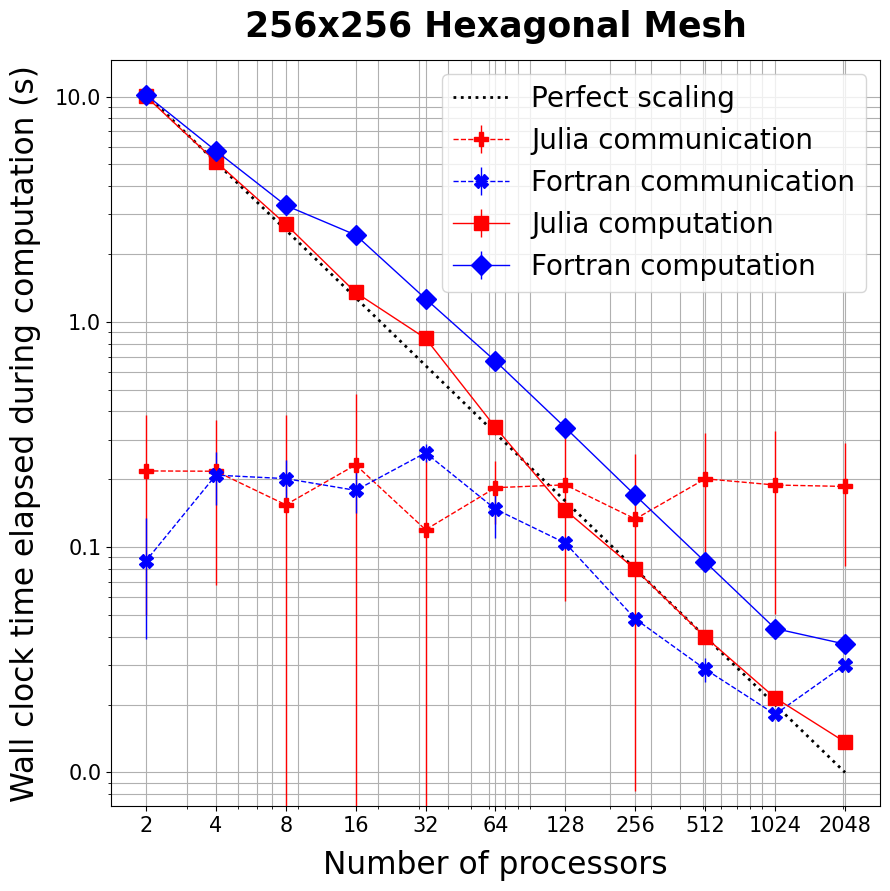

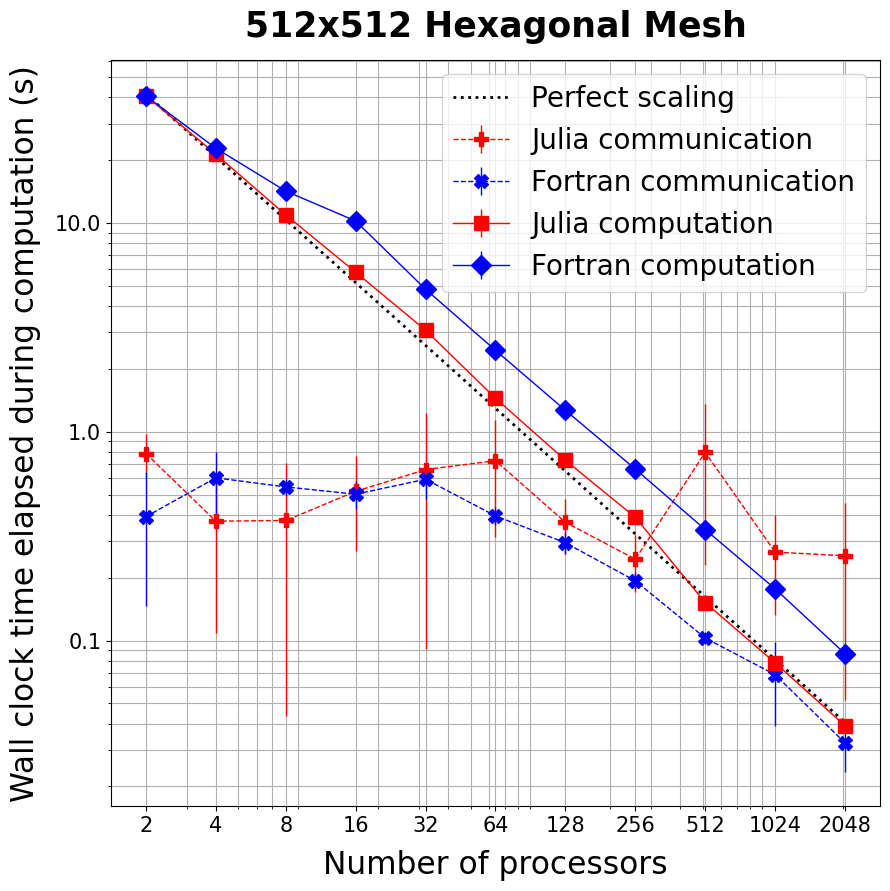

In [15]:
for nCellsX in [128, 256, 512]
    juliasim, juliampi, juliaprocs, fortransim, fortranmpi, fortranprocs, juliafname, fortranfname, juliasimstd, juliampistd, fortransimstd, fortranmpistd = juliafortrantimesplits(nCellsX, 2048, 2048)
    fig, ax = strongscalingplot2(juliasim, juliasimstd, juliampi, juliampistd, juliaprocs, fortransim, fortransimstd, fortranmpi, fortranmpistd, fortranprocs, nCellsX)
    
    if savefigs
        fig.savefig("$(juliafname)_scaling_$(nCellsX)x_sim_and_mpi.pdf", bbox_inches="tight")
        println("saved")
    end
    println(juliafname, fortranfname)
end

In [17]:
function timesplitplot(nprocs, comptime, mpitime, nCellsX, info="")
    fontscale = 2
    
    fig, ax = plt.subplots(1,1, figsize=(length(comptime)*3,8))
#     df = DataFrame(processors=nprocs, computation=comptime, communication=mpitime)
#     df.plot(kind="bar", 
#             stacked=true, 
#             colormap="tab10", 
#             figsize=(10, 6))
    totals = comptime + mpitime
    
    ax.bar(string.(Int.(nprocs)), comptime ./ totals, color="blue", label="Computation")
    ax.bar(string.(Int.(nprocs)), mpitime ./ totals, bottom=comptime ./ totals, color="red", label="Communication")
    
    ax.legend(loc="center left", fontsize=20*fontscale, bbox_to_anchor=(1,0.5))
    
    ax.set_yticks([0.0, 0.5, 1.0])
    ax.set_xlabel("Number of processors", fontsize=25*fontscale, labelpad=10.0*fontscale)
    ax.set_ylabel("Proportion of time", fontsize=25*fontscale, labelpad=10.0*fontscale)
    ax.tick_params(axis="x", labelsize=20*fontscale)
    ax.tick_params(axis="y", labelsize=20*fontscale)
    
    # " using $(nCellsX)x$(nCellsX) Hexagonal Mesh"
    ax.set_title("$info: Proportion of Simulation Time \nSpent on Computation and Communication", fontweight="bold", fontsize=30*fontscale, y=1.08)
    
#     plt.tick_params(top="off", bottom="off", left="off", right="off", labelleft="off", labelbottom="on")
    
    # plt.tight_layout()
    
    return fig, ax
end

timesplitplot (generic function with 2 methods)

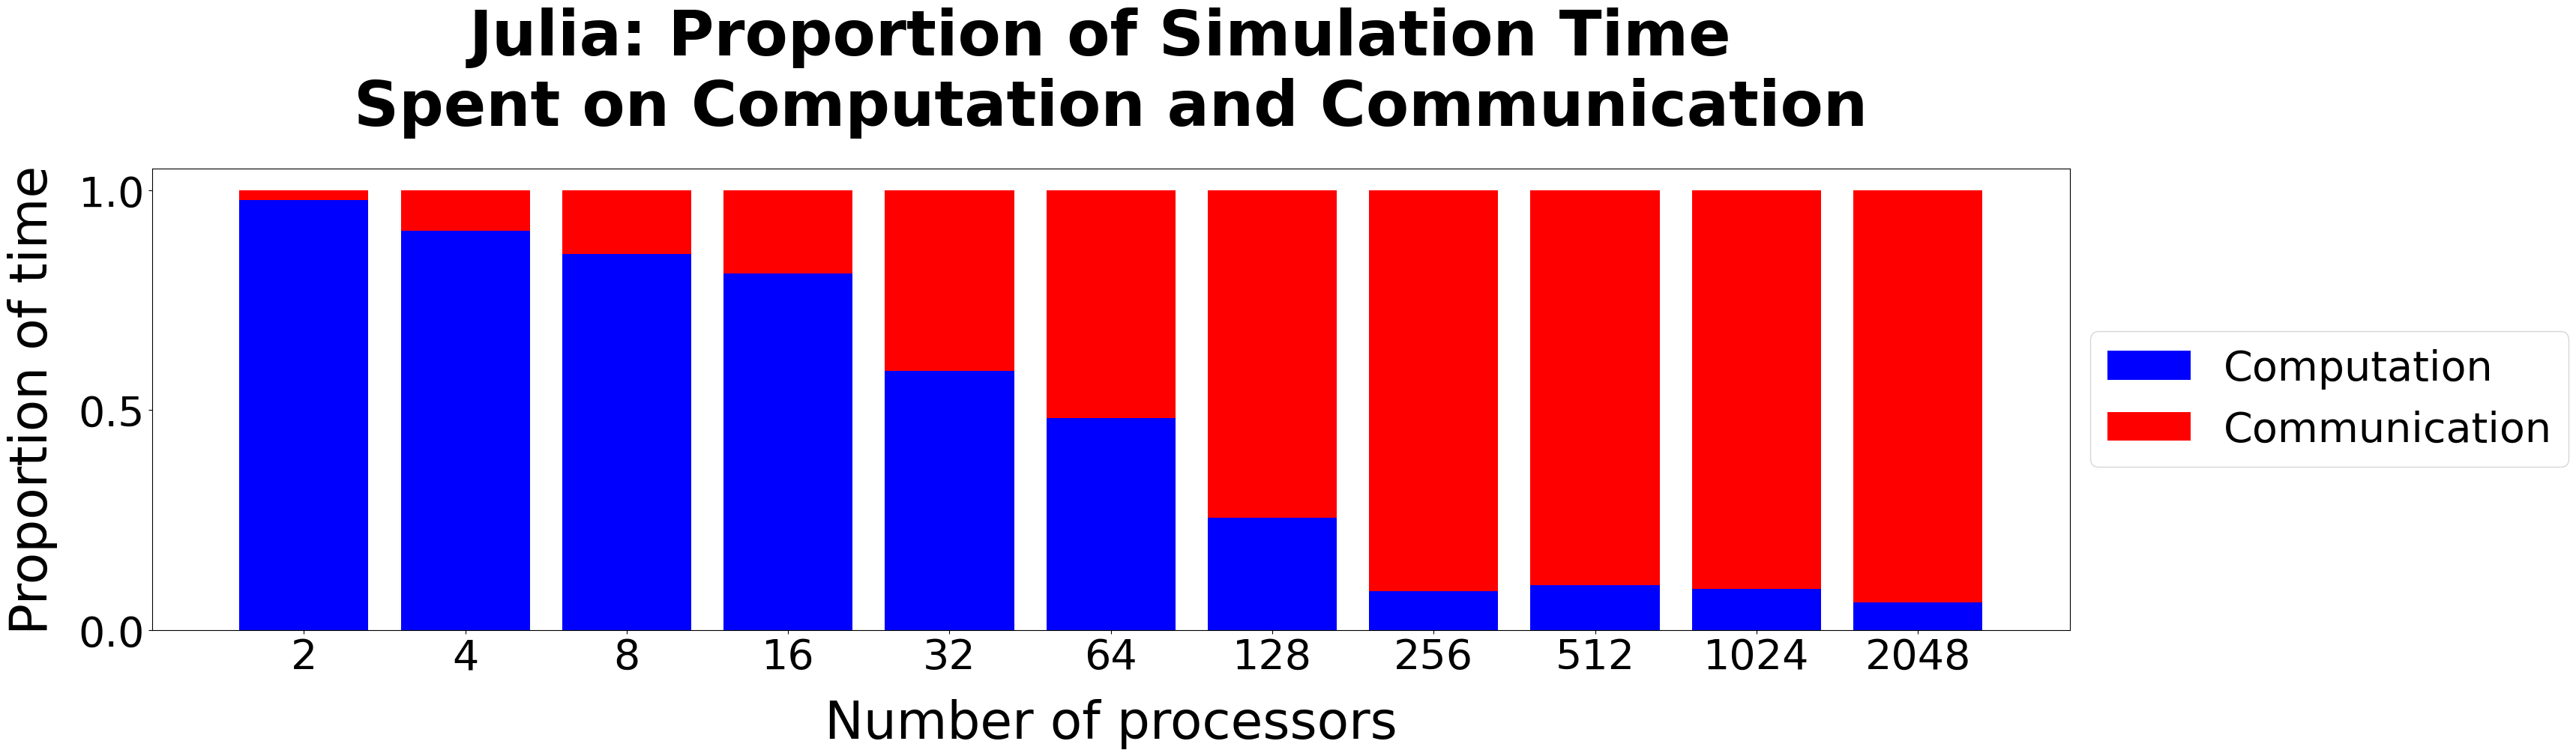

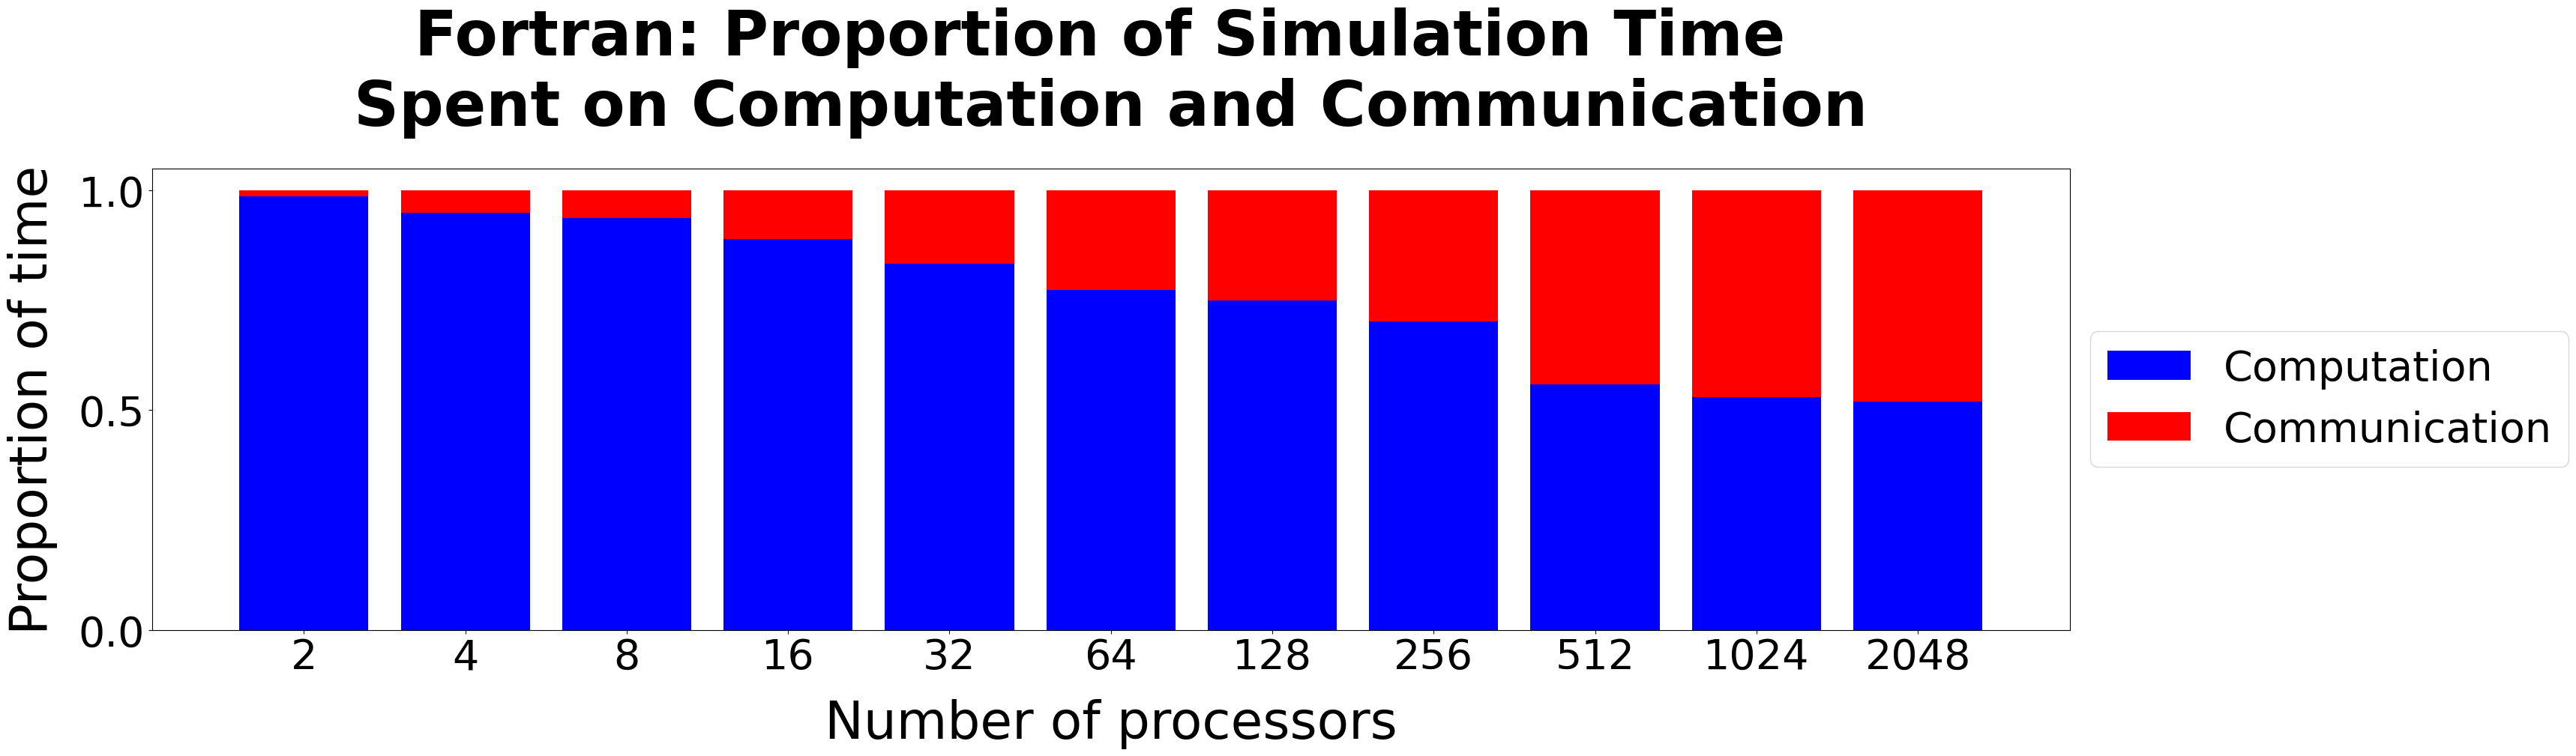

In [19]:
nCellsX = 128
juliasim, juliampi, juliaprocs, fortransim, fortranmpi, fortranprocs, juliafname, fortranfname, juliasimstd, juliampistd = juliafortrantimesplits(nCellsX, 2048, 2048)

fig, ax = timesplitplot(juliaprocs, juliasim, juliampi, nCellsX, "Julia")
fig.savefig("$(juliafname)_proportion_sim_mpi.pdf", bbox_inches="tight")
fig, ax = timesplitplot(fortranprocs[end:-1:1], fortransim[end:-1:1], fortranmpi[end:-1:1], nCellsX, "Fortran")
fig.savefig("$(fortranfname)_proportion_sim_mpi.pdf", bbox_inches="tight")

In [13]:
juliafname

"/global/u2/r/rstrauss/repos/MPAS_Ocean_Julia/output/kelvinwave/../../output/kelvinwave/resolution128x128/procs2048/steps10/nvlevels100/2022-09-06T22:17:58.045.txt"

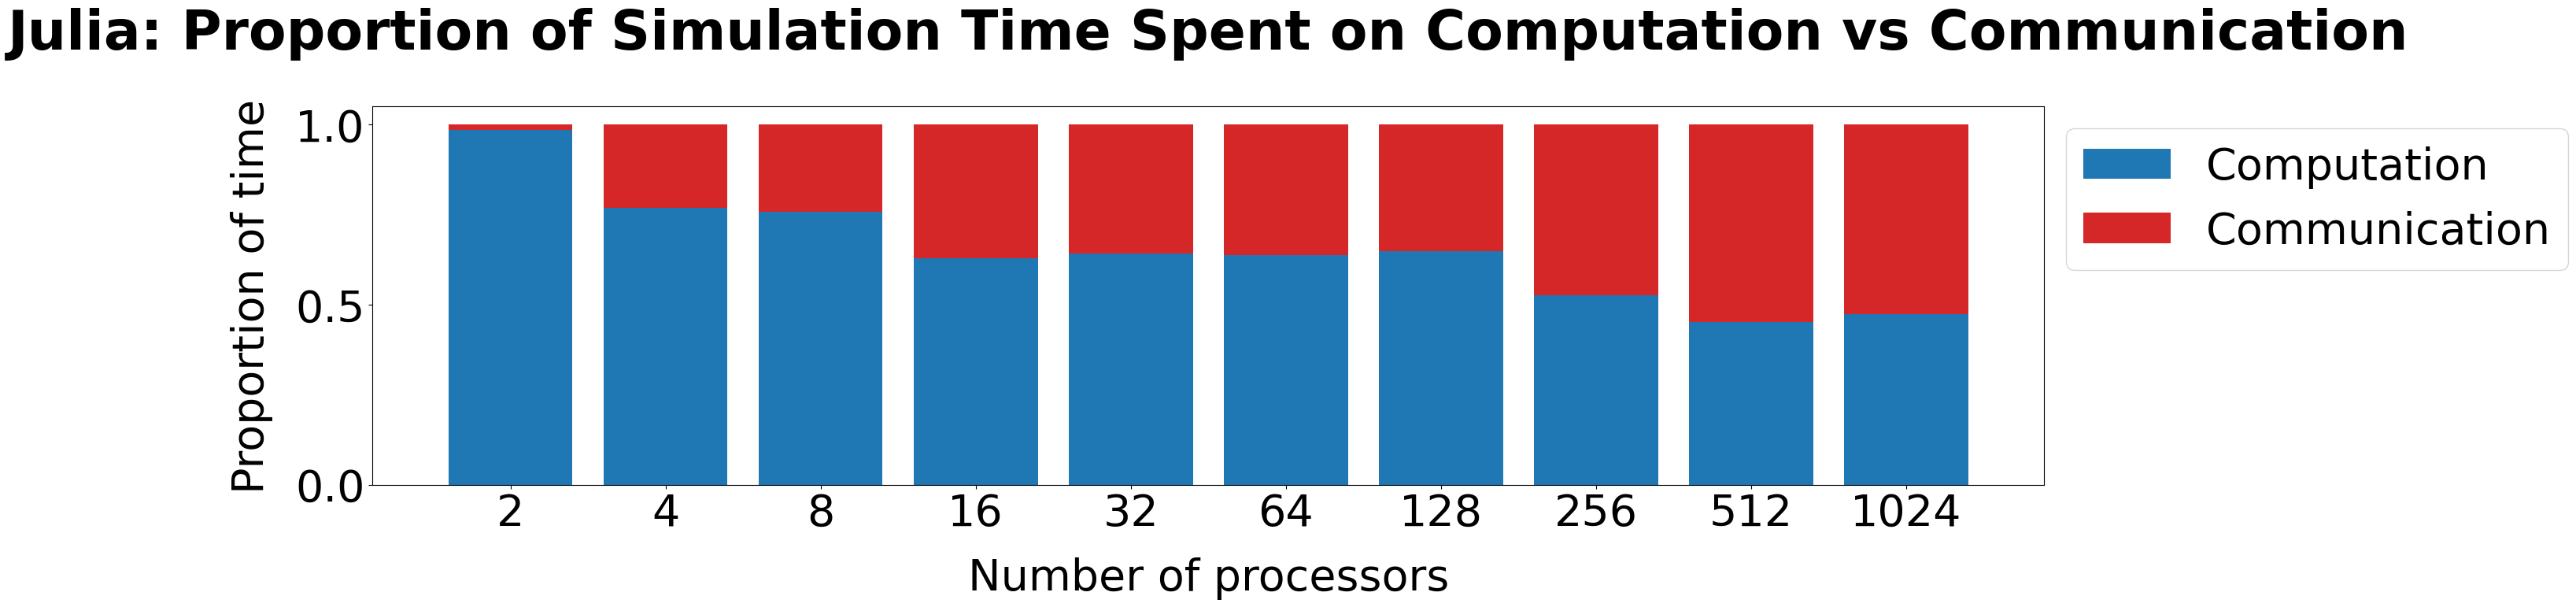

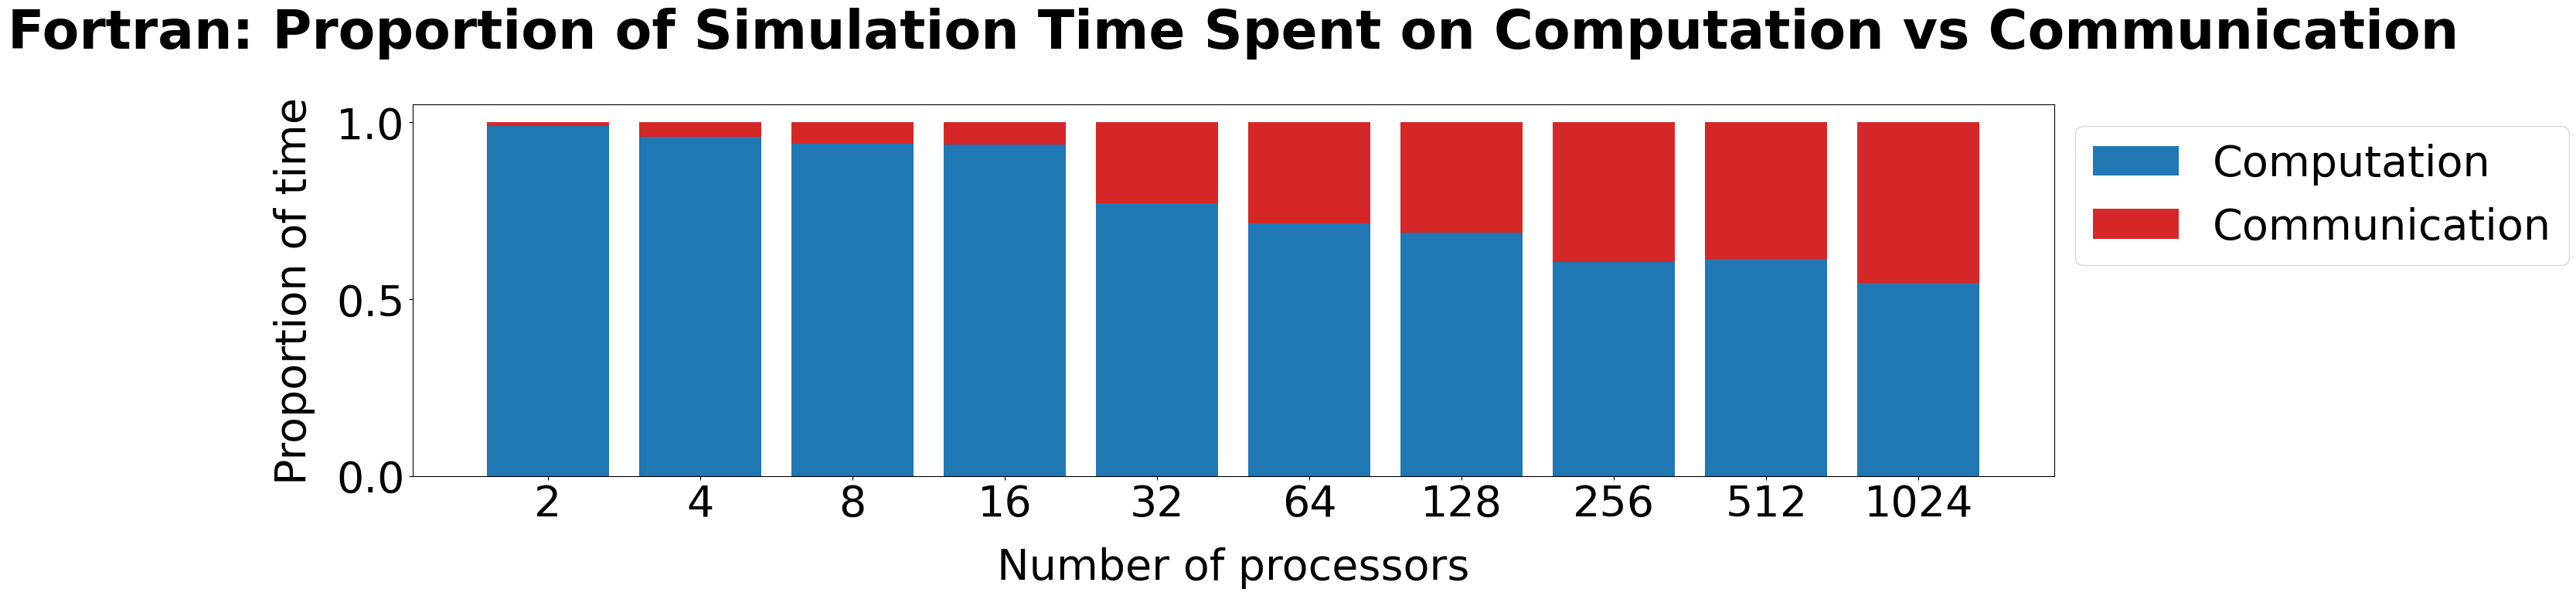

(Figure(PyObject <Figure size 3000x800 with 1 Axes>), PyObject <AxesSubplot: title={'center': 'Fortran: Proportion of Simulation Time Spent on Computation vs Communication'}, xlabel='Number of processors', ylabel='Proportion of time'>)

In [14]:
nCellsX = 256
juliasim, juliampi, juliaprocs, fortransim, fortranmpi, fortranprocs, juliafname, fortranfname = juliafortrantimesplits(nCellsX, 1024, 4096)
fig, ax = timesplitplot(juliaprocs, juliasim, juliampi, nCellsX, "Julia")
# fig.savefig("$(juliafname)_proportion_sim_mpi.pdf")
fig, ax = timesplitplot(fortranprocs[end:-1:3], fortransim[end:-1:3], fortranmpi[end:-1:3], nCellsX, "Fortran")
# fig.savefig("$(fortranfname)_proportion_sim_mpi.pdf")

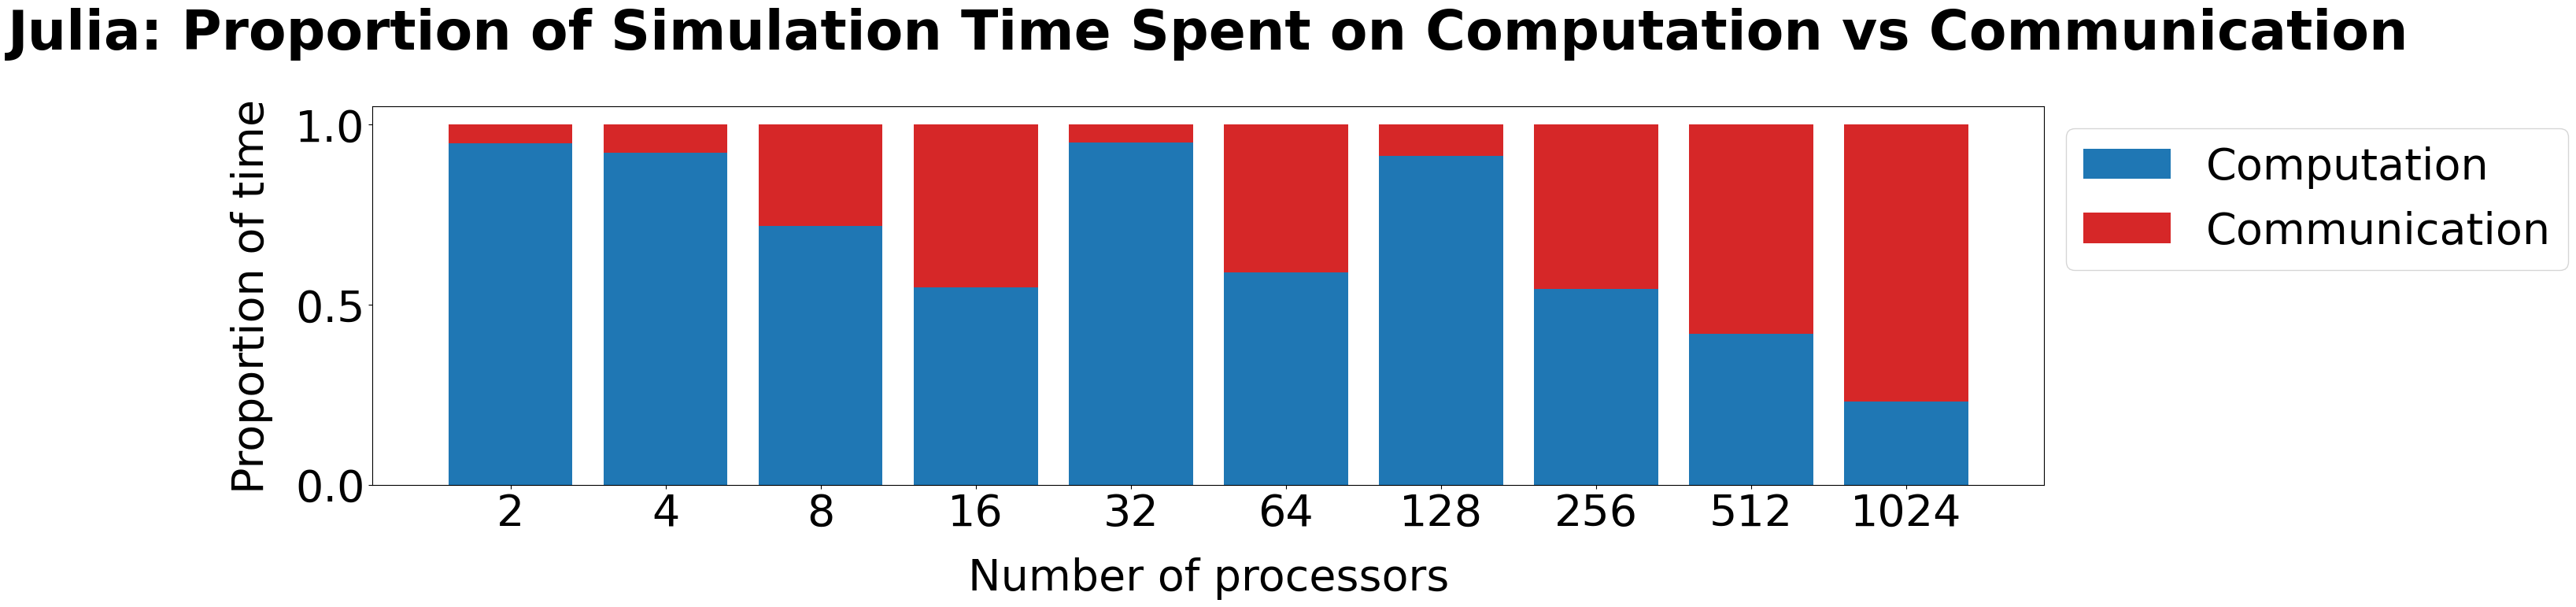

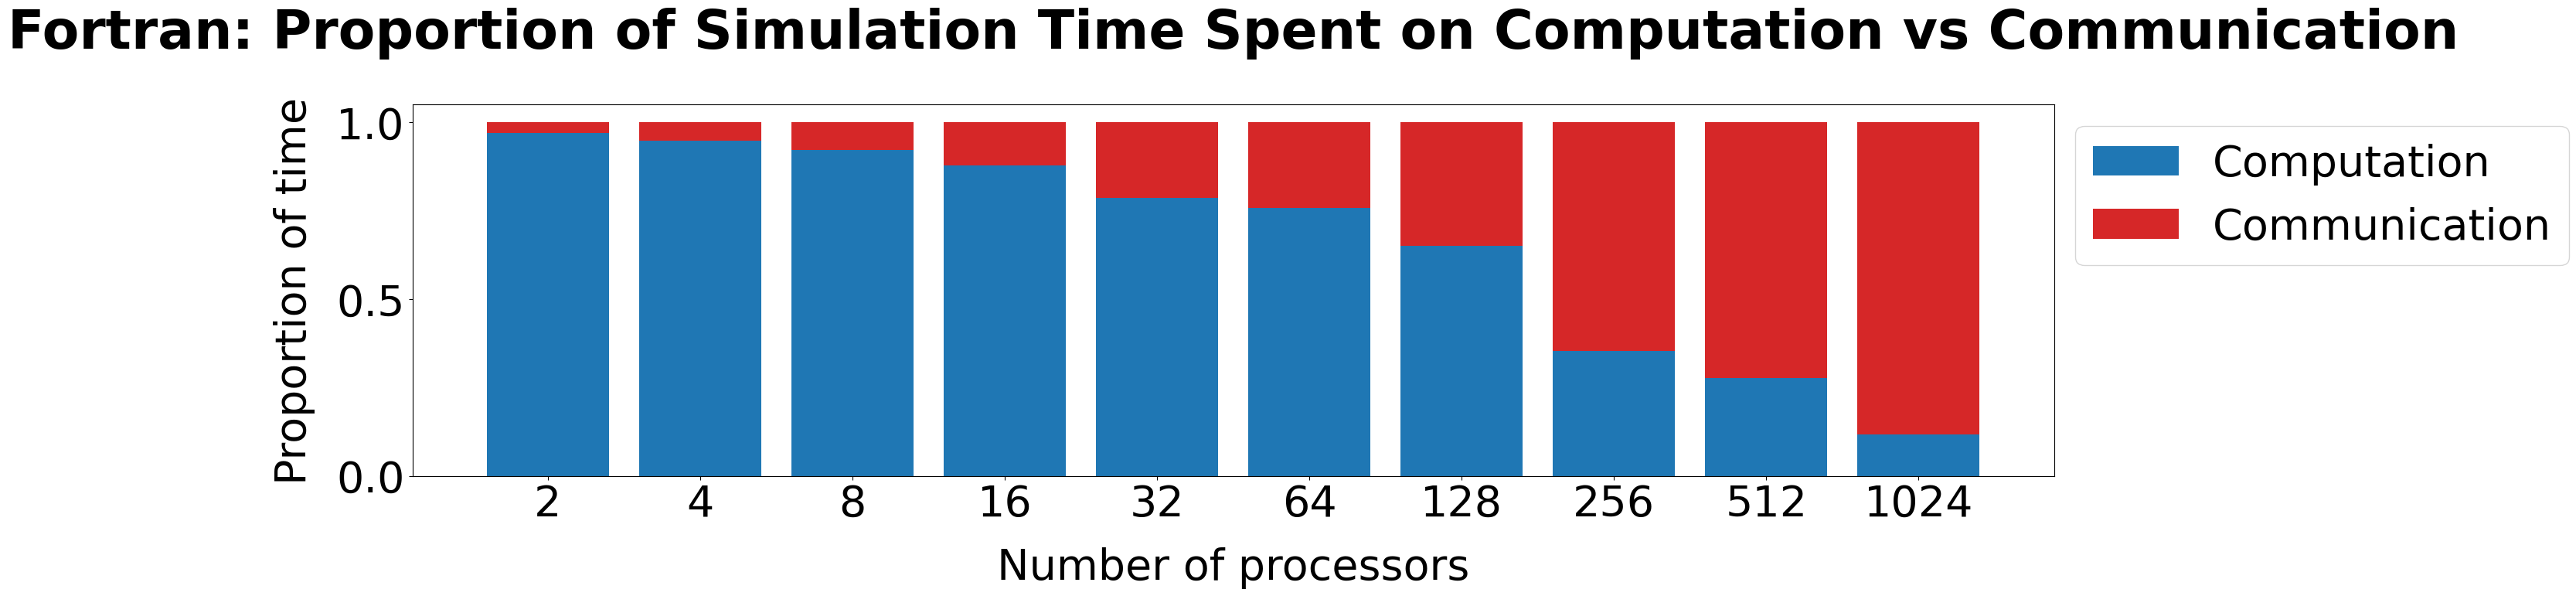

In [8]:
nCellsX = 128
juliasim, juliampi, juliaprocs, fortransim, fortranmpi, fortranprocs, juliafname, fortranfname = juliafortrantimesplits(nCellsX, 1024, 4096)
fig, ax = timesplitplot(juliaprocs, juliasim, juliampi, nCellsX, "Julia")
# fig.savefig("$(juliafname)_proportion_sim_mpi.pdf")
fig, ax = timesplitplot(fortranprocs[end:-1:3], fortransim[end:-1:3], fortranmpi[end:-1:3], nCellsX, "Fortran")
# fig.savefig("$(fortranfname)_proportion_sim_mpi.pdf")

In [ ]:
function weakscalingplot()
    resolutions = [128, 256, 512]
    cellsperproclines = [64^2, 64^2 /2, 64^2/4]
    juliatimes = zeros((length(resolutions),length(cellsperproclines)))
    fortrantimes = zeros((length(resolutions),length(cellsperproclines)))
    fnames = Vector{String}(undef, 4)

    for (i, nCellsX) in enumerate(resolutions)
        juliameans, juliaprocs, fortranmeans, fortranprocs, fnames[i] = juliafortranmeans(nCellsX)

        ind = findall(cpp -> cpp in cellsperproclines, nCellsX^2 ./ juliaprocs)
        juliatimes[i,:] = juliameans[ind]

        ind = findall(cpp -> cpp in cellsperproclines, nCellsX^2 ./ fortranprocs)
        fortrantimes[i,:] = fortranmeans[ind]
    end

    fig, ax = plt.subplots(1,1, figsize=(9,9))

    julialines = ax.loglog(resolutions, juliatimes)
    fortranlines = ax.loglog(resolutions, fortrantimes, linestyle="--")
    ax.set_xlabel("Number of cells (X)")
    ax.set_ylabel("Wallclock time elapsed during computation")
    ax.legend(julialines, cellsperproclines, title="cells per process (julia)", loc="upper left")
    ax.legend(fortranlines, cellsperproclines, title="cells per process (fortran)", loc="upper right")

    display(fig)

    return fig
end

weakscalingplot()





# fig.savefig("/tmp/plot.png")